In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler


Dieses notebook beschäftigt sich hauptsächlich mit der visuellen Aufbereitung der logit regressions Analysen. Als features wurde die mittlere Änderungsrate der Stabilitätsindizes verwendet in einem 12h Fenster vor der Sprengung verwendet. Das gesamte data wrangling um diese Größen aus dem .pro zu ziehen wurde hier bereits erledigt.

In [4]:
def sm_logit_plot(X_passed, y_passed, results_passed, parameter):
    """creates fancy plots for statsmodels.api.Logit.fit data. 
    X_passed ... single regression feature
    y_passed ... label
    results_passed ... statsmodels.api.Logit.fit
    parameter ... parameter name
    """
    global lgd, acr # pyplot.savefig() needs these to set right fig size. globals bad but me lazy...
                
                        ### some calculations to plot later on ###
    # calculates turning point of the sigmoid func by solvin .5 = 1/(1+exp(-(beta_0 + beta_1*x)))
    x_TP = -results_passed.params[0]/results_passed.params[1]

    ### seperates bad predictions
    yass = [] 
    nah =   []
    for x_, y_ in zip(X_passed, y_passed):
        if x_>x_TP and y_==0:  # false positive
            nah.append((x_, y_))
        elif x_<x_TP and y_==1:  # false negative
            nah.append((x_, y_))
        else: yass.append((x_, y_))

    # calculates p(x) to plot sigmoid
    # https://de.wikipedia.org/wiki/Logistische_Regression
    x_it = np.linspace(-(max(abs(X_passed))+0.5), (max(abs(X_passed))+0.5), 300)
    lin_predict = results_passed.params[0] + results_passed.params[1]*x_it
    inv_logit = 1/(1 + np.exp(-lin_predict))

    # calculates p(x) for inherited x
    # some jazz needed for the thin lines from the measured points to the fit 
    x_vodoo = []
    y_vodoo = []
    for x_, y_ in zip(X_passed, y_passed):
        lin_predict_re = results_passed.params[0] + results_passed.params[1]*x_
        inv_logit_re = 1/(1 + np.exp(-lin_predict_re))
        x_vodoo.append([x_]*2)
        y_vodoo.append([y_, inv_logit_re])

    # confusion matrix to plot patches with true positive, false, positive, true negative...
    predicted = (results_passed.predict(sm.add_constant(X_passed))>0.5).astype(int) #... binary class
    cf = confusion_matrix(y_passed, predicted)  # see: sklearn.metrics.confusion_matrix

    # calculates accuracy
    accuracy = np.mean(y_passed == predicted)
    
                            ### plot ###
    # header
    plt.clf()
    fig, ax = plt.subplots(1, figsize=(12,6), dpi=100)
    fig.suptitle("log. Reg. für {}".format(parameter), x=0.2, y=0.92, ha="center")
    ax.set_title("statsmodels.api.Logit()", loc="right")
    ax.axis([-(max(abs(X_passed))+0.3), max(abs(X_passed))+0.3, -0.05, 1.05])
    
    #axes
    ax.axhline(0.5, color="black", alpha=0.9, linewidth=0.8)
    ax.axvline(x_TP, color="black", alpha=0.9, linewidth=0.8)
    # fited sigmoid curve
    ax.plot(x_it, inv_logit, linewidth=3, color="tomato", zorder=2, label=r"$P~( Y = 1~ |~ X) ~=~ \frac{1}{1+e^{-(\beta_{0}+\beta_{1}\cdot x)}}$ mit Modellkoeffizienten $\beta_{i}$.")            
    # markers on fit
    ax.scatter(X_passed, [j[1] for j in y_vodoo], zorder=3, marker="o", edgecolor="black", facecolor="skyblue", s= 50, label=r"$P~(Y=1~|~X)$ für den Datensatz.")
    # green and red flags aka measured data
    ax.scatter(*zip(*yass), color="limegreen", marker="|", zorder=10, s=250, label="Korrekt modelliert.")
    ax.scatter(*zip(*nah), color="firebrick", marker="|", zorder=10, s=250, label="Falsch modelliert.") 
    #thin lines
    for x_, y_ in zip(x_vodoo, y_vodoo):
        ax.plot(x_, y_, color="gray", linestyle="-", zorder=1, linewidth=0.7, alpha=0.3)

                                ### patches ###
    # false negative
    props = dict(boxstyle="round", facecolor="firebrick", edgecolor="black", alpha=0.5)
    ax.text(0.13, 0.63, "FN: \n{}".format(cf[1][0]), transform=ax.transAxes, bbox=props, fontsize=16, ha="center", fontweight="bold", zorder=6)
    # true positive
    props = dict(boxstyle="round", facecolor="limegreen", edgecolor="black", alpha=0.5)
    ax.text(0.87, 0.63, "TP: \n{}".format(cf[0][0]), transform=ax.transAxes, bbox=props, fontsize=16, ha="center", fontweight="bold", zorder=6)
    # false positive
    props = dict(boxstyle="round", facecolor="firebrick", edgecolor="black", alpha=0.5)
    ax.text(0.87, 0.28, "FP: \n{}".format(cf[0][1]), transform=ax.transAxes, bbox=props, fontsize=16, ha="center", fontweight="bold", zorder=6)
    # true negative
    props = dict(boxstyle="round", facecolor="limegreen", edgecolor="black", alpha=0.5)
    ax.text(0.13, 0.28, "TN: \n{}".format(cf[1][1]), transform=ax.transAxes, bbox=props, fontsize=16, ha="center", fontweight="bold", zorder=6)
    # accuracy patch
    props = dict( facecolor="white", edgecolor="black", alpha=1)
    acr = ax.text(0.2, -0.2, "accuracy: {:.2f}".format(accuracy), transform=ax.transAxes, bbox=props, fontsize=16, ha="center", fontweight="bold", zorder=6)
    # legend
    lgd = ax.legend(fontsize=14, loc="lower right", bbox_to_anchor=(1,-0.4))
    plt.show()
    return(fig)



In [15]:
# loads data
mitÄnderung_12 = pd.read_pickle("./output/mitAEnderung_12_norm.pkl")
print("shape: ", mitÄnderung_12.shape)
mitÄnderung_12.head(4)

shape:  (40, 5)


,k: stability class,k: Sdef,k: Sn38,k: Sk38,Lawine
0,2.334869,0.256256,0.341803,3.388414,1
1,-0.059868,-0.111702,0.194791,-0.650859,1
2,-2.454606,0.203691,0.047779,-3.396303,0
3,-0.059868,-0.111702,0.488815,0.232732,1


In [16]:
mitÄnderung_12["Lawine"].value_counts()

1    24
0    16
Name: Lawine, dtype: int64

Um den Datensatz zu balancieren wird SMOTE (sythetic minority oversampling technique) verwendet.

In [17]:
# splits dataframe
X = mitÄnderung_12.drop("Lawine", axis=1)
y = mitÄnderung_12.loc[:,"Lawine"]
smote = SMOTE(random_state=7)
X_res, y_res = smote.fit_resample(X,y)

In [18]:
y_res.value_counts()

1    24
0    24
Name: Lawine, dtype: int64

In [19]:
# multivariates log reg model
model = sm.Logit(y_res, X_res)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.536720
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   48
Model:                          Logit   Df Residuals:                       44
Method:                           MLE   Df Model:                            3
Date:                Mon, 15 Jun 2020   Pseudo R-squ.:                  0.2257
Time:                        11:17:07   Log-Likelihood:                -25.763
converged:                       True   LL-Null:                       -33.271
Covariance Type:            nonrobust   LLR p-value:                  0.001802
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
k: stability class    -0.4315      0.536     -0.804      0.421      -1.483       0.620
k: Sd

Da die Stabilitätsindizes nicht unabhänging sind, werden sie ab jetzt einzeln betrachtet.

Optimization terminated successfully.
         Current function value: 0.629581
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   48
Model:                          Logit   Df Residuals:                       46
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Jun 2020   Pseudo R-squ.:                 0.09171
Time:                        11:17:12   Log-Likelihood:                -30.220
converged:                       True   LL-Null:                       -33.271
Covariance Type:            nonrobust   LLR p-value:                   0.01350
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0200      0.306      0.065      0.948      -0.580       0.620
k: Sk38        1.0481      0.

<Figure size 432x288 with 0 Axes>

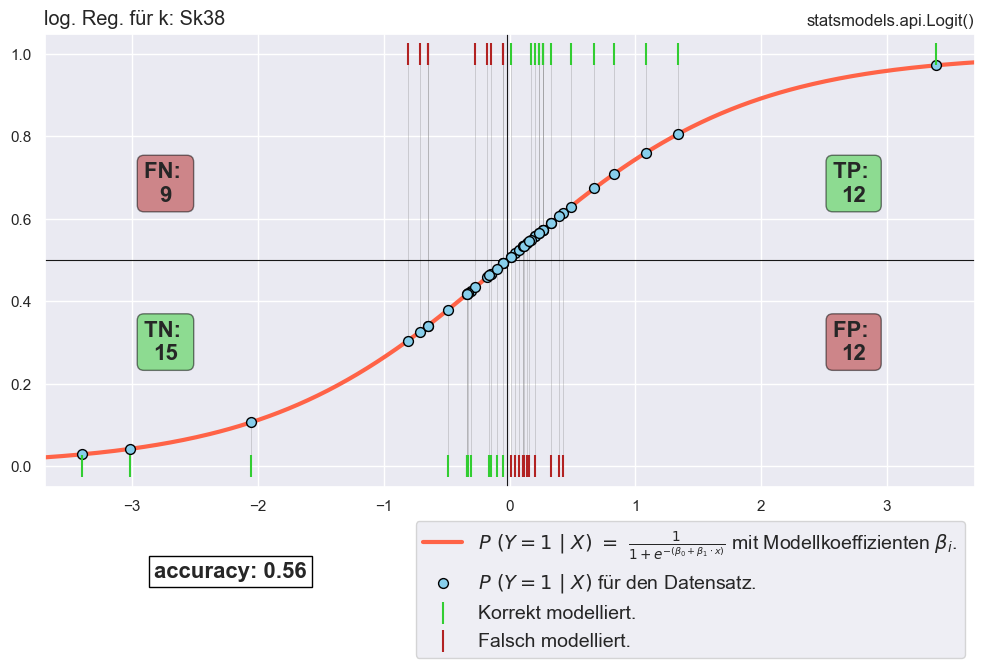

In [20]:
                        ### Sk38 ##
# log reg model
model = sm.Logit(y_res, sm.add_constant(X_res["k: Sk38"]))
results = model.fit()
print(results.summary())
# calls plot func 
fig = sm_logit_plot(X_res["k: Sk38"], y_res, results, "k: Sk38")
#fig.savefig("./output/test_plot.png", bbox_extra_artists=(lgd, acr), bbox_inches="tight") #bboxes outside axes need some love

Optimization terminated successfully.
         Current function value: 0.631564
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   48
Model:                          Logit   Df Residuals:                       46
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Jun 2020   Pseudo R-squ.:                 0.08885
Time:                        11:17:16   Log-Likelihood:                -30.315
converged:                       True   LL-Null:                       -33.271
Covariance Type:            nonrobust   LLR p-value:                   0.01504
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2052      0.381     -0.538      0.590      -0.952       0.542
k: Sdef        1.7602      1.

<Figure size 432x288 with 0 Axes>

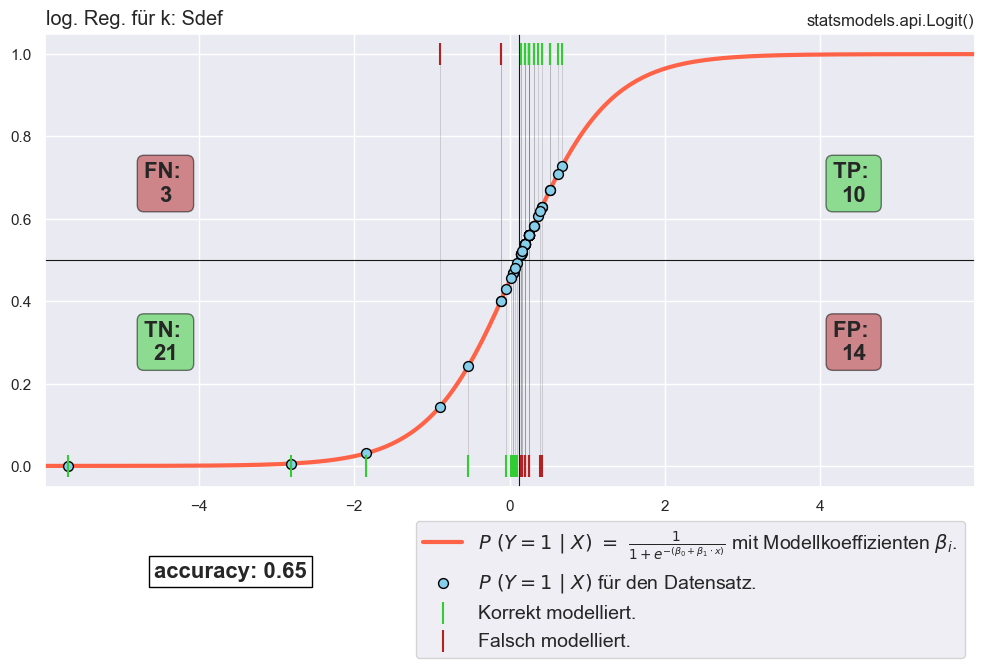

In [21]:
model = sm.Logit(y_res, sm.add_constant(X_res["k: Sdef"]))
results = model.fit()
print(results.summary())
tex = results.summary().as_latex()
foo = sm_logit_plot(X_res["k: Sdef"], y_res, results, "k: Sdef")

#with open("./output/teX_test.tex", "x") as f:
 #   f.write(tex)

Optimization terminated successfully.
         Current function value: 0.682719
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   48
Model:                          Logit   Df Residuals:                       46
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Jun 2020   Pseudo R-squ.:                 0.01504
Time:                        11:17:21   Log-Likelihood:                -32.771
converged:                       True   LL-Null:                       -33.271
Covariance Type:            nonrobust   LLR p-value:                    0.3170
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.292      0.011      0.992      -0.569       0.575
k: Sn38        0.3129      0.

<Figure size 432x288 with 0 Axes>

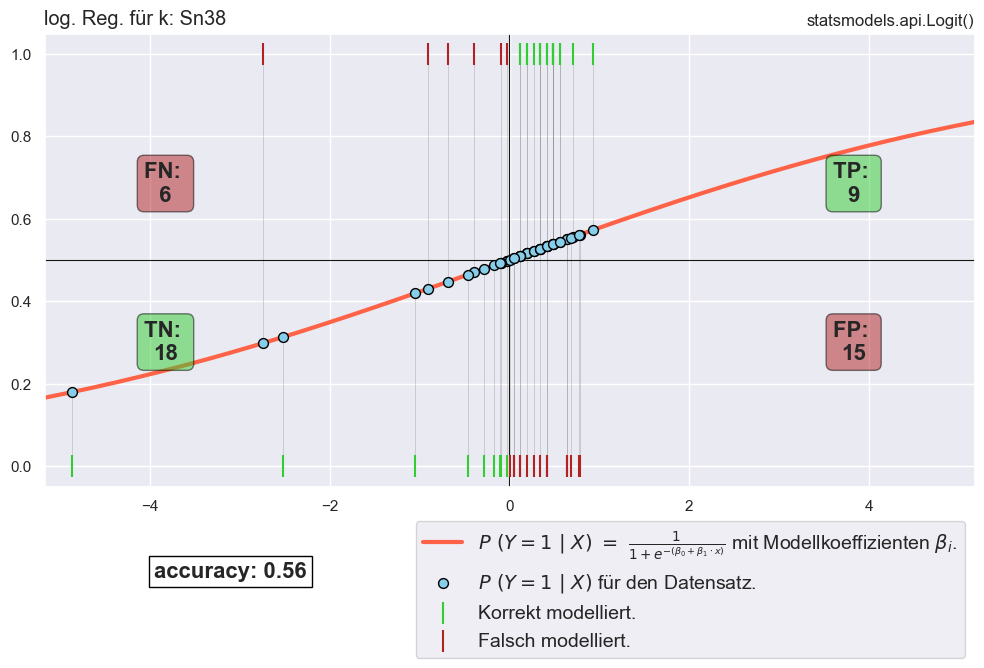

In [22]:
model = sm.Logit(y_res, sm.add_constant(X_res["k: Sn38"]))
results = model.fit()
print(results.summary())
foo = sm_logit_plot(X_res["k: Sn38"], y_res, results, "k: Sn38")

Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   48
Model:                          Logit   Df Residuals:                       46
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Jun 2020   Pseudo R-squ.:                0.001533
Time:                        11:17:37   Log-Likelihood:                -33.220
converged:                       True   LL-Null:                       -33.271
Covariance Type:            nonrobust   LLR p-value:                    0.7495
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0004      0.289      0.001      0.999      -0.566       0.567
k: st

<Figure size 432x288 with 0 Axes>

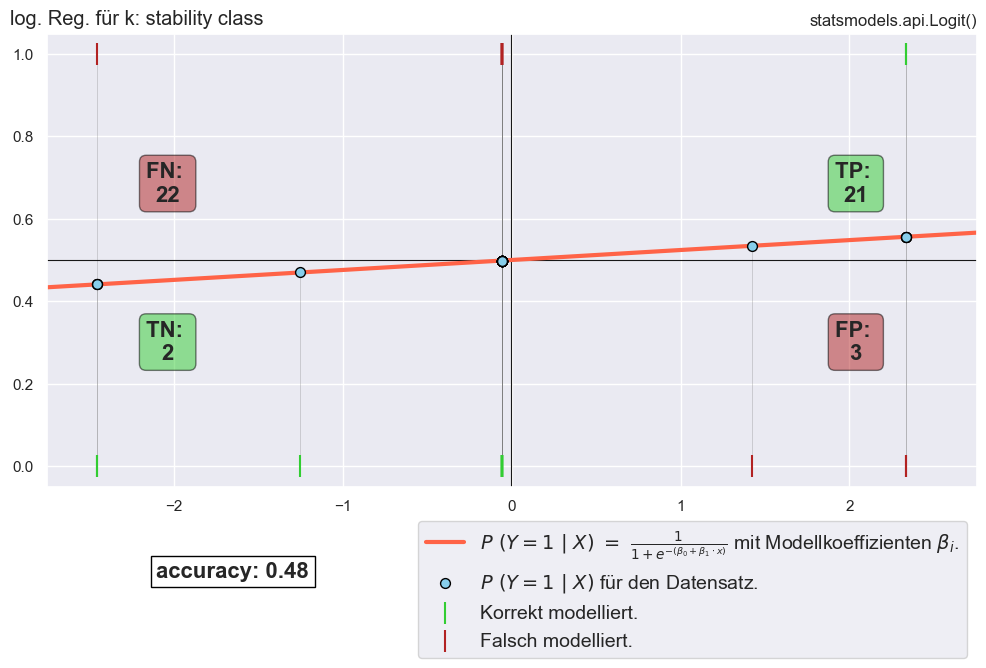

In [24]:
model = sm.Logit(y_res, sm.add_constant(X_res["k: stability class"]))
results = model.fit()
print(results.summary())
foo = sm_logit_plot(X_res["k: stability class"], y_res, results, "k: stability class")

## Spielerei
hier noch eine kleine spielerei; nachfolgende zelle ist etwas gefinkelter, es wird eine pipeline erstellt. diese nimmt zuerst synthetische datensatz gewichtung vor, dabei findet zuerst SMOTE oversampling gefolgt von rand() undersampling statt und anschließend wird ein decision tree modell damit gefüttert. zur auswahl der trainingsdaten wird ein stratified k-fold algorithmus verwendet, der faltungsparameter durchläuft 1,2,3, ... , 1o dabei wird der roc_auc_score (fläche unter receiver operating characteristic) ausgegeben um die model güte zu beurteilen...

In [34]:
X_p = sm.add_constant(X["k: Sk38"])

for k in range(1,11):
    #pipeline
    steps =[("over", SMOTE(k_neighbors=k)),("under", RandomUnderSampler()), ("model", DecisionTreeClassifier())]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X_p, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    print('Mean ROC AUC: %.3f' % np.mean(scores))
  

Mean ROC AUC: 0.729
Mean ROC AUC: 0.738
Mean ROC AUC: 0.721
Mean ROC AUC: 0.733
Mean ROC AUC: 0.725
Mean ROC AUC: 0.736
Mean ROC AUC: 0.725
Mean ROC AUC: 0.724
Mean ROC AUC: 0.733
Mean ROC AUC: 0.719


Auf den ersten Blick scheint dieses Modell bessere Ergebnisse zu liefern...